In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import itertools
from os import path
import pickle
from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
# %matplotlib notebook
plt.rcParams['figure.figsize'] = [20, 13]

import pandas as pd
pd.options.display.width = 200

slam_node_colors = {'gmapping': 'orange', 'slam_toolbox': 'blue', 'hector_slam': 'cyan'}


In [2]:
def load_cache(file_path):
    with open(path.expanduser(file_path), 'rb') as f:
        cache_dict = pickle.load(f)
        return cache_dict['df']

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [3]:
# load data from cache and rename columns
df_new_config = load_cache("/home/enrico/ds/performance_modelling/output/slam_new_config/run_data_per_waypoint_cache.pkl")
# df_many_odoms = load_cache("/home/enrico/ds/performance_modelling/output/slam_many_odoms/run_data_per_waypoint_cache.pkl")
# df = df_new_config.append(df_many_odoms)
df = df_new_config
df.rename(inplace=True, columns={
    'trajectory_length_trajectory_length': 'trajectory_length',
    'waypoint_relative_localization_error_translation_error_final': 'translation_error',
    'waypoint_relative_localization_error_rotation_error_final': 'rotation_error',
    'geometric_similarity_sensor_mean_of_translation_eigenvalues_ratio_all': 'tgs_cont',
    'lidar_visibility_mean_visible_ranges_ratio': 'lvr_cont',
    'waypoint_start_time': 'start_time_cont',
})

# refactor and extract additional parameters and metrics
df['linear_update'] = df['linear_angular_update'].apply(lambda x: x[0])
df['beta'] = df['beta'].apply(lambda x: max(x))
df['norm_translation_error'] = df.translation_error / df.trajectory_length
df['run_id'] = df['run_folder'].apply(lambda x: path.basename(x))
df['waypoint_index'] = df.sort_values('start_time_cont').groupby(df.run_id).cumcount()
df['accumulated_trajectory_length'] = df.sort_values('start_time_cont').groupby(df.run_id).trajectory_length.cumsum() - df.trajectory_length

# discretize continuous input metrics
df['tgs'] = pd.cut(df.tgs_cont, 10, labels=False)
df['lvr'] = pd.cut(df.lvr_cont, 10, labels=False)
df['start_time'] = pd.cut(df.start_time_cont, 10, labels=False)

# drop unnecessary datapoints
# df = df[(
#     ((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5) |
# )]
df = df[((df.slam_node == 'gmapping') | (df.slam_node == 'slam_toolbox')) & (df.linear_update == 0.5)]
df = df[df.trajectory_length > 1]

# only keep necessary columns
robot_parameters = [
    'laser_scan_max_range',
    'laser_scan_fov_deg',
    'beta',
]
other_parameters = [
    'slam_node',
    'environment_name',
]
input_discretized_metrics = [
    'start_time',
    'tgs',
    'lvr',
]
input_continuous_metrics = [
    'waypoint_index',
    'accumulated_trajectory_length',
    'start_time_cont',
    'tgs_cont',
    'lvr_cont',
]
output_metrics = [
    'norm_translation_error',
]
df = df[
    robot_parameters +
    other_parameters +
    input_discretized_metrics +
    input_continuous_metrics +
    output_metrics
]

mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

printmd("## Parameters and Their Values")
for c in robot_parameters + other_parameters + input_discretized_metrics:
    printmd("{:>30}".format(c), sorted(list(df[c].unique())))

## Parameters and Their Values

          laser_scan_max_range [3.5, 8.0, 15.0, 30.0]

            laser_scan_fov_deg [90, 180, 270, 359]

                          beta [0.0, 2.0]

                     slam_node ['gmapping', 'slam_toolbox']

              environment_name ['7A-2', 'airlab', 'fr079', 'office_b']

                    start_time [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

                           tgs [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

                           lvr [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

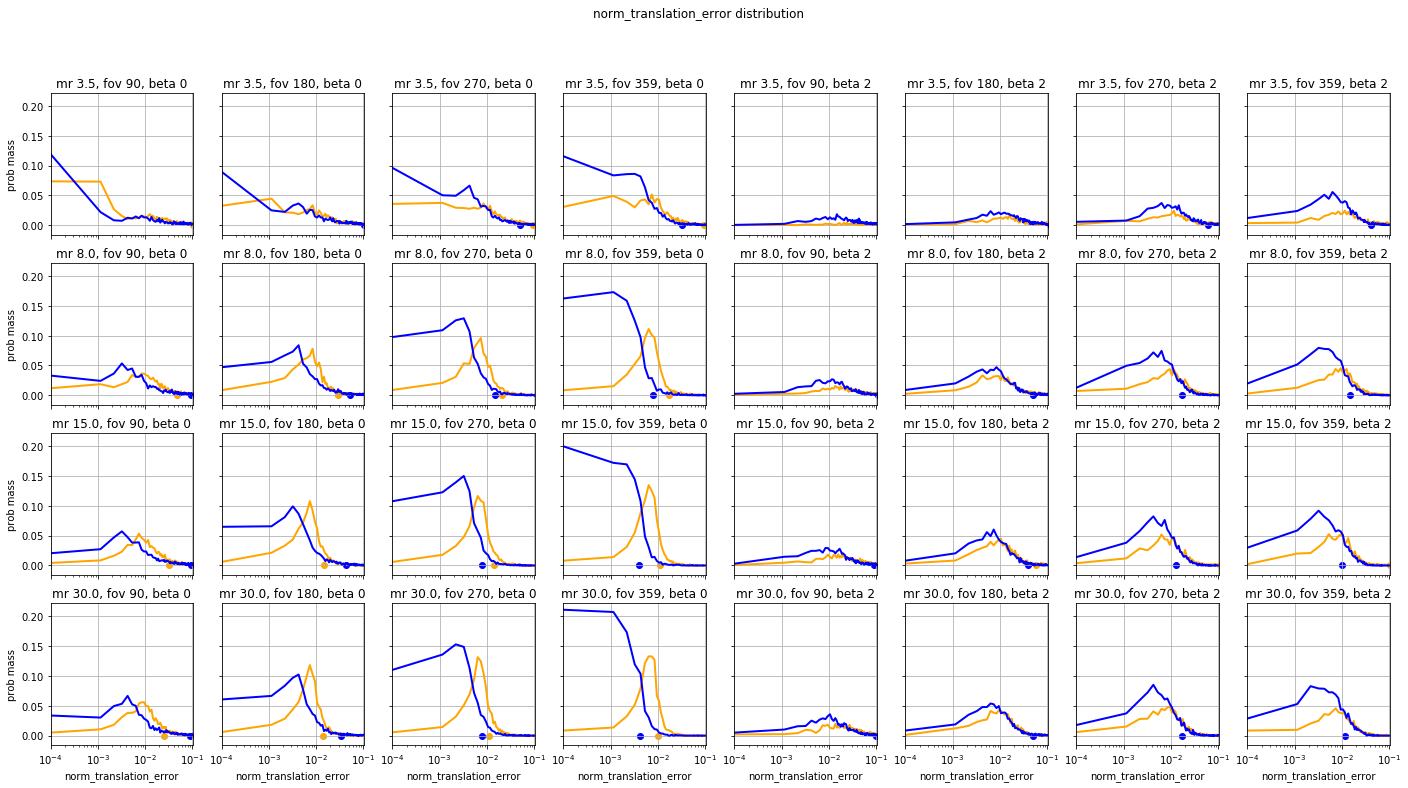

In [8]:
hist_metric = df.norm_translation_error
mean = hist_metric.mean()
x_lim_min = 0.0001
x_lim_max = 0.103
x = np.linspace(x_lim_min, x_lim_max, 100)
mrs = sorted(list(df.laser_scan_max_range.unique()))
fovs = sorted(list(df.laser_scan_fov_deg.unique()))
betas = sorted(list(df.beta.unique()))
betas_fovs = list(itertools.product(betas, fovs))

fig, axs = plt.subplots(len(mrs), len(betas_fovs), sharex='all', sharey='all')
fig.set_size_inches([24, 12])
axs[0, 0].set_xscale('log')
axs[0, 0].set_xlim(x_lim_min, x_lim_max)

for i, mr in enumerate(mrs):
    for j, (beta, fov) in enumerate(betas_fovs):
        for slam_node in df.slam_node.unique():
            df_ = df[
                (df.slam_node == slam_node) &
                (df.laser_scan_max_range == mr) &
                (df.laser_scan_fov_deg == fov) &
                (df.beta == beta)
            ]
            h_y, h_x = np.histogram(df_[hist_metric.name], bins=x)
            n = len(df_[hist_metric.name])
            axs[i, j].plot(h_x[:-1], h_y/n, linewidth=2, color=slam_node_colors[slam_node])
            axs[i, j].scatter(df_[hist_metric.name].mean(), 0, color=slam_node_colors[slam_node])

        axs[i, j].set_title(f"mr {mr}, fov {fov}, beta {int(beta)}")
        axs[i, j].set(xlabel=hist_metric.name, ylabel='prob mass')
        axs[i, j].label_outer()
        axs[i, j].grid(True)

plt.grid(True)
plt.suptitle(f"{hist_metric.name} distribution")
plt.show()

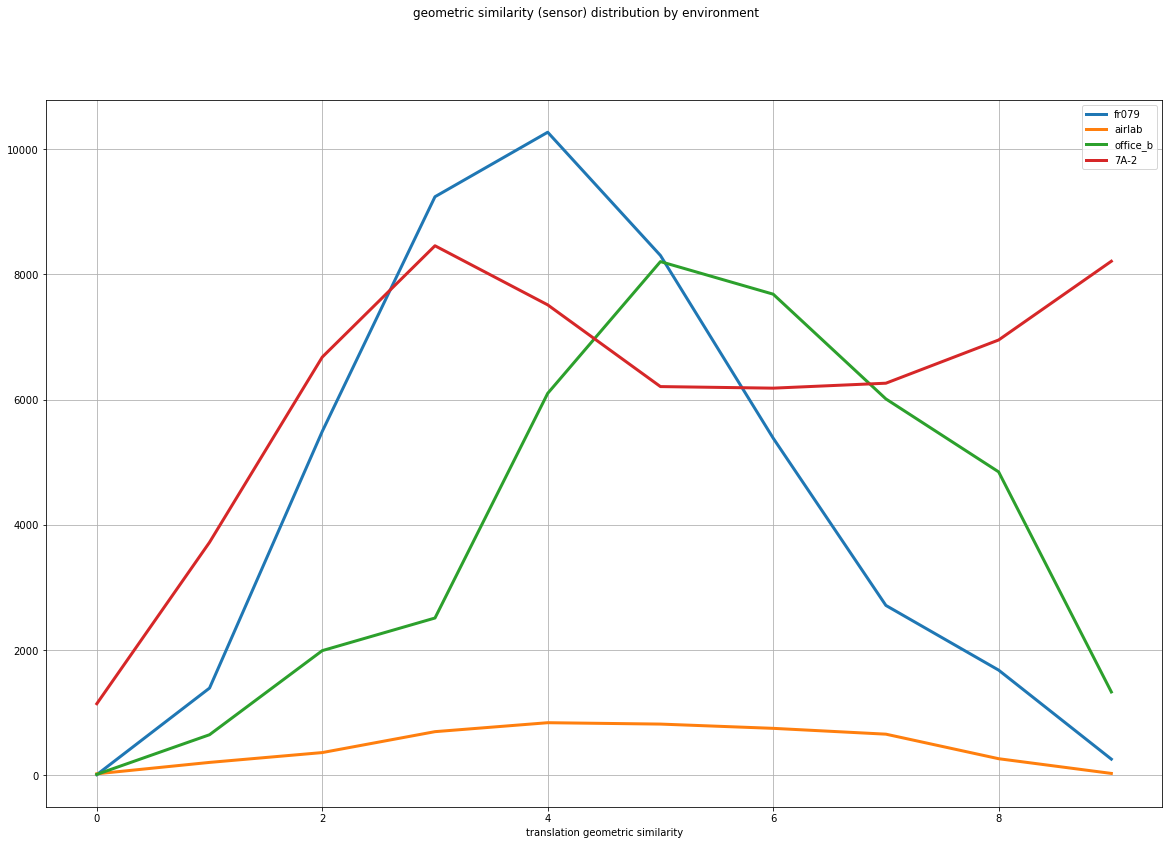

In [5]:
plt.xlabel('translation geometric similarity')
for env_name in df.environment_name.unique():
    df_hist = df[df.environment_name == env_name].groupby(df.tgs).tgs.count()
    plt.plot(df_hist.index, df_hist, label=env_name, linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("geometric similarity (sensor) distribution by environment")
plt.show()

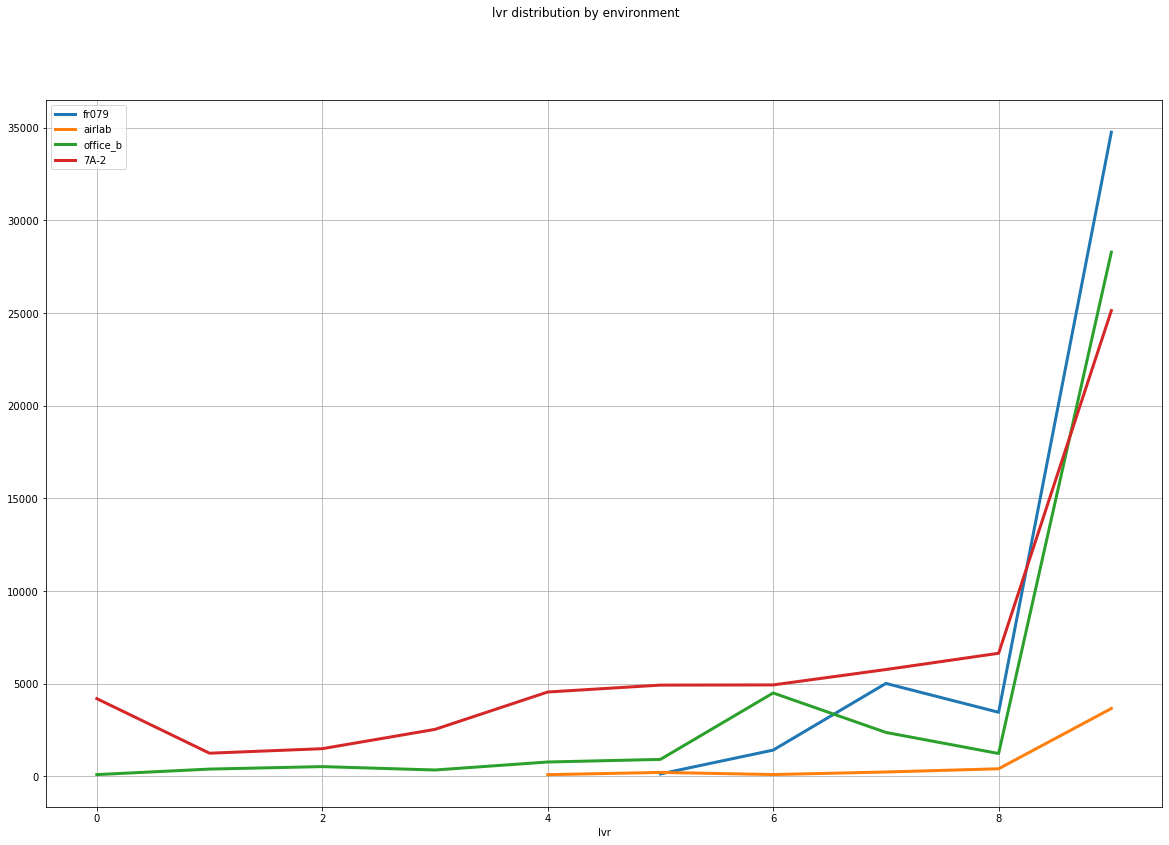

In [6]:
plt.xlabel('lvr')
for env_name in df.environment_name.unique():
    df_hist = df[df.environment_name == env_name].groupby(df.lvr).lvr.count()
    plt.plot(df_hist.index, df_hist, label=env_name, linewidth=3)
plt.legend()
plt.grid(True)

plt.suptitle("lvr distribution by environment")
plt.show()